<a href="https://colab.research.google.com/github/tnwls6865/cau_mAI_tutorial/blob/main/Week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Linear Classifier 

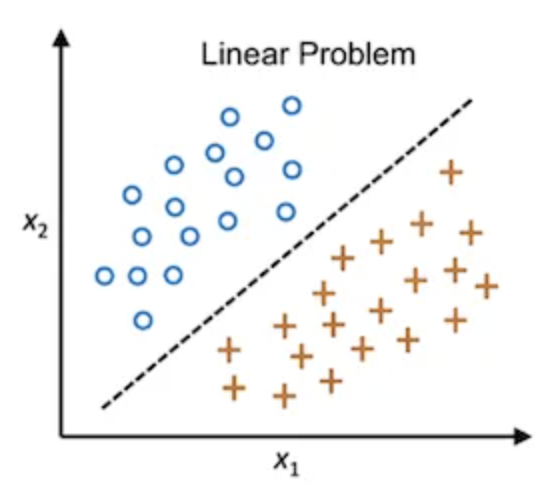


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from keras.datasets import cifar10

c:\Users\cau\miniconda3\envs\het\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

(X_train, y_train) , (X_test, y_test) = cifar10.load_data()
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# valdiation set
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# training set
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# development set
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# test set
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]


print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000, 1)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000, 1)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000, 1)


In [3]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print ('Training data shape: ', X_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Test data shape: ', X_test.shape)
print ('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


In [4]:

mean_image = np.mean(X_train, axis=0).astype('uint8')

X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [43]:
class LinearClassifier(object):

  def __init__(self):
    self.W = None

  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
      
    """
    Inputs:
    - X: array (N, D) training data; N : 샘플 갯수 D 차원 
    - y: array (N,) training labels; y[i] = c : 0 <= c < C for C classes
    - learning_rate: (float)
    - reg: (float) regularization 강도
    - num_iters: (integer) number of steps 
    - batch_size: (integer) number of training examples 
    - verbose: (boolean) If true, print progress

    Outputs: 각 training iteration에서 loss function value를 포함하고 있는 list
    """


    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # y는 0...K-1 를 갖는다고 가정 (K는 classes 개수)
    if self.W is None:
      # 초기화
      self.W = 0.001 * np.random.randn(dim, num_classes)

    # gradient descent W
    loss_history = []
    for it in range(num_iters):
      X_batch = None
      y_batch = None
      
      # batch size로 샘플링
      random_idxs = np.random.choice(num_train, batch_size)
      X_batch = X[random_idxs]
      y_batch = y[random_idxs]

      # loss 와 gradient 계산하기
      loss, grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)

      self.W -= learning_rate * grad

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return loss_history

  def predict(self, X):

    y_pred = np.zeros(X.shape[1])

    # prediction(y_pred)에서 가장 높은 값 추출
    y_pred = np.argmax(np.dot(X, self.W), axis=1)
    
    return y_pred
  
  def loss(self, W, X_batch, y_batch, reg):

    pass


def svm_loss_vectorized(W, X, y, reg):


  C = W.shape[1]
  N = X.shape[0]
  loss = 0.0
  dW = np.zeros(W.shape) # initialize the gradient as zero

  scores = np.dot(X, W)    # (N, C)
  
  correct_scores = scores[np.arange(N), y]  # (N, )
  margins = np.maximum(scores - correct_scores.reshape(N, 1) + 1.0, 0)  # (N, C)
  margins[np.arange(N), y] = 0
  loss = np.sum(margins) / N
  loss += 0.5 * reg * np.sum(W * W)

  
  dscores = np.zeros_like(scores)  # (N, C)
  dscores[margins > 0] = 1  
  dscores[np.arange(N), y] -= np.sum(dscores, axis=1)   #  (N, 1) = (N, 1)

  dW = np.dot(X.T, dscores) 
  dW /= N
  dW += reg * W 

  return loss, dW

def softmax_loss_vectorized(W, X, y, reg):

  # Initialize the loss and gradient to zero.
  N = X.shape[0]
  loss = 0.0
  dW = np.zeros_like(W)

  
  # forward
  score = np.dot(X, W)   # (N, C)
  out = np.exp(score)
  out /= np.sum(out, axis=1, keepdims=True)   # (N, C)
  loss -= np.sum(np.log(out[np.arange(N), y]))
  loss /= N
  loss += 0.5 * reg * np.sum(W**2)

  # backward
  dout = np.copy(out)   # (N, C)
  dout[np.arange(N), y] -= 1
  dW = np.dot(X.T, dout)  # (D, C)
  dW /= N
  dW += reg * W

  return loss, dW


In [44]:


class LinearSVM(LinearClassifier):
  """ A subclass that uses the Multiclass SVM loss function """

  def loss(self, X_batch, y_batch, reg):
      return svm_loss_vectorized(self.W, X_batch, y_batch, reg)


class Softmax(LinearClassifier):
  """ A subclass that uses the Softmax + Cross-entropy loss function """

  def loss(self, X_batch, y_batch, reg):
    return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)


In [45]:
import time

svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train.flatten(), learning_rate=1e-7, reg=5e4, num_iters=1500, verbose=True)
toc = time.time()
print ('That took %fs' % (toc - tic))

r_i [40598 26991  3655 15966 43694 46597 47858 20872 20790 38898 44876 27613
 42991 19993  3696 25633 36476 43708 18566 33914 37626 33622 15988  4181
 36205 13177  7987 36942 21863 47442 47099 38127 48272 47696  6785   980
 36477 48748 38974 47533 24983  2708 11353 42189 14271 31427 10841 27452
 14863 48368  8699  5363 40262  4175  4246 33439 44883 26577  2610 23240
 41123 22384 12463 33388 39047 31487 15517 14760 18180 17263 47561 47113
 45920  2492 42490 21340 32978 11764 13619  7558 43795 28838  7194 20988
 22591 43624 31203  6632  5170 26027 25251  6346   658 36437 10044 20962
 45999 16645 30212 22413  7844 25046 18344 35891 14631   813 34940 36273
 37989 15752 31421 11578 12123 15253  8138 16958 25067 11530 16185 11253
 37214 20898 40187 26837 36663 48529 27249  4573 35460  7635  7148 42649
 30182  2011 13871  3545 33631 32966  4499 37261  4405 35529 46883  3952
 18037 22202 28727 24407  3850 39962 39083  7543 21604 36109  3979 21041
  6374 30290 13571 40604  5665 45272 44066  707

KeyboardInterrupt: 

In [ ]:

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

### Gradient Descent 

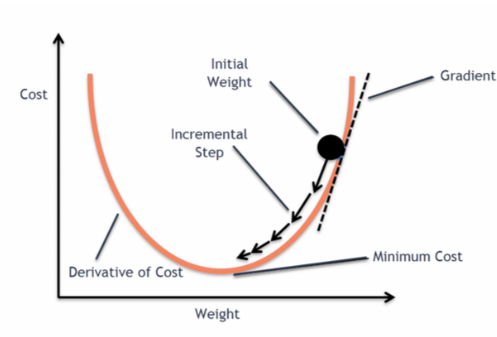

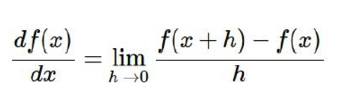

함수의 최소값을 찾는 문제에서 활용 \\
미분 값은 곧 해당 지점에서의 기울기

In [ ]:
import numpy as np

def numerical_gradient(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]
        # f(x+h) 계산 
        x[idx] = tmp_val + h
        fxh1 = f(x)

        # f(x-h) 계산 
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
    
    return grad


def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x

    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x

$$f(x_0, x_1) = x_0^2 + x_1^2$$




In [ ]:
def function_2(x):
    return x[[0]]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100)

In [ ]:
# 학습률이 너무 큰 예 : lr=10.0
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=10.0, step_num=100)

In [ ]:
# 학습률이 너무 작은 예 : lr=1e-10
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=1e-10, step_num=100)

### Training Neural Network
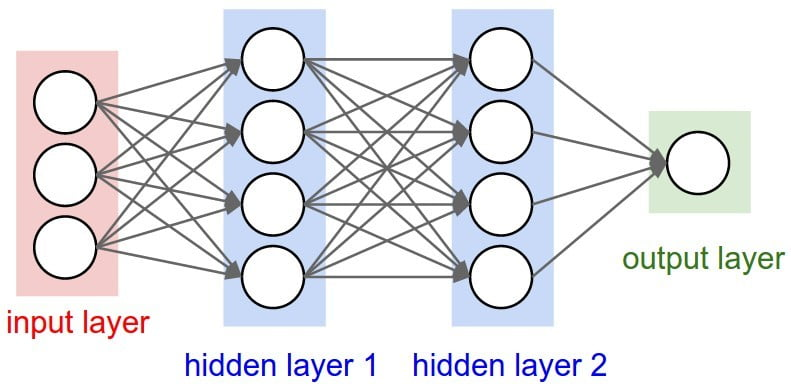

In [ ]:
class TwoLayerNet(object):
  """
  
  input - fully connected layer - ReLU - fully connected layer - softmax

  """

  def __init__(self, input_size, hidden_size, output_size, std=1e-4):
    """

    W1: First layer weights;  shape (D, H)
    b1: First layer biases;   shape (H,)
    W2: Second layer weights; shape (H, C)
    b2: Second layer biases;  shape (C,)

    """
    self.params = {}
    self.params['W1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = std * np.random.randn(hidden_size)  + 0.5  # np.zeros(hidden_size) 
    self.params['W2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

  def loss(self, X, y=None, reg=0.0):
    
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    N, D = X.shape

    # Compute the forward pass
    scores = None
   
   ################
   #######code#####
   ################
   # fully connected layer - ReLU - fully connected layer

    if y is None:
      return scores

    # loss 계산
    loss = 0.0
    
   ################
   #######code#####
   ################
   # softmax probabilities 계산 

    
    # softmax loss 계산
    loss -= np.sum(np.log(out[np.arange(N), y]))
    loss /= N
    loss += 0.5 * reg * (np.sum(W1**2) + np.sum(W2**2))
    
    # Backward pass : gradient계산
    grads = {}

    ################
    #######code#####
    ################
    # parameters에 대한 gradient 계산 (backpropagation)


    
    # add reg term
    grads['W2'] += reg * W2
    grads['W1'] += reg * W1

    return loss, grads

  def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
  
    num_train = X.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)

    # Use SGD to optimize the parameters in self.model
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    for it in range(num_iters):
      X_batch = None
      y_batch = None
        
      random_idxs = np.random.choice(num_train, batch_size)
      X_batch = X[random_idxs]
      y_batch = y[random_idxs]
    
      # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
      loss_history.append(loss)

      
      ################
      #######code#####
      ################
      # parameter update

      self.params['W2'] -= learning_rate * grads['W2']
      self.params['b2'] -= learning_rate * grads['b2']
      self.params['W1'] -= learning_rate * grads['W1']
      self.params['b1'] -= learning_rate * grads['b1']
        
      
      if verbose and it % 100 == 0:
        print ('iteration %d / %d: loss %f' % (it, num_iters, loss))

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(X_batch) == y_batch).mean()
        val_acc = (self.predict(X_val) == y_val).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Decay learning rate
        learning_rate *= learning_rate_decay

    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

  def predict(self, X):
   
    y_pred = None
    params = self.params

    ################
    #######code#####
    ################
    # prediction


    return y_pred




In [ ]:
input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
  np.random.seed(0)
  return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
  np.random.seed(1)
  X = 10 * np.random.randn(num_inputs, input_size)
  y = np.array([0, 1, 2, 2, 1])
  return X, y

net = init_toy_model()
X, y = init_toy_data()

In [ ]:
scores = net.loss(X)
print ('Your scores:')
print (scores)

print ('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print (correct_scores)


# The difference should be very small. We get < 1e-7
print ('Difference between your scores and correct scores:')
print (np.sum(np.abs(scores - correct_scores)))

In [ ]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=1e-5,
            num_iters=100, verbose=False)

print ('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

In [ ]:
from keras.datasets import cifar10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
   
    # Load the raw CIFAR-10 data
    (X_train, y_train) , (X_test, y_test) = cifar10.load_data()
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0).astype('uint8')
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

In [ ]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train.flatten(), X_val, y_val.flatten(),
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.5, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val.flatten()).mean()
print ('Validation accuracy: ', val_acc)


In [ ]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

In [ ]:
import math 
def visualize_grid(Xs, ubound=255.0, padding=1):
  """
  Reshape a 4D tensor of image data to a grid for easy visualization.

  Inputs:
  - Xs: Data of shape (N, H, W, C)
  - ubound: Output grid will have values scaled to the range [0, ubound]
  - padding: The number of blank pixels between elements of the grid
  """
  (N, H, W, C) = Xs.shape
  grid_size = int(math.ceil(math.sqrt(N)))
  grid_height = H * grid_size + padding * (grid_size - 1)
  grid_width = W * grid_size + padding * (grid_size - 1)
  grid = np.zeros((grid_height, grid_width, C))
  next_idx = 0
  y0, y1 = 0, H
  for y in range(grid_size):
    x0, x1 = 0, W
    for x in range(grid_size):
      if next_idx < N:
        img = Xs[next_idx]
        low, high = np.min(img), np.max(img)
        grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
        # grid[y0:y1, x0:x1] = Xs[next_idx]
        next_idx += 1
      x0 += W + padding
      x1 += W + padding
    y0 += H + padding
    y1 += H + padding
  # grid_max = np.max(grid)
  # grid_min = np.min(grid)
  # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
  return grid


In [ ]:

# Visualize the weights of the network

def show_net_weights(net):
  W1 = net.params['W1']
  W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
  plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
  plt.gca().axis('off')
  plt.show()

show_net_weights(net)

## TODO : Neural Network hyperparameter 변경해서 학습하고 어떻게 결과가 나오는지 확인해보기